In [13]:
# Import libraries

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


In [19]:
# Read specific cleaned dataset and 

data = pd.read_csv('lstm_data.csv')
data.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Datetime
0,AL012004,ALEX,20040731,1800,30.3,-78.3,25,1010,0,0,...,0,0,0,0,0,0,0,0,0,2004-07-31 18:00:00
1,AL012004,ALEX,20040801,0,31.0,-78.8,25,1009,0,0,...,0,0,0,0,0,0,0,0,0,2004-08-01 00:00:00
2,AL012004,ALEX,20040801,600,31.5,-79.0,25,1009,0,0,...,0,0,0,0,0,0,0,0,0,2004-08-01 06:00:00
3,AL012004,ALEX,20040801,1200,31.6,-79.1,30,1009,0,0,...,0,0,0,0,0,0,0,0,0,2004-08-01 12:00:00
4,AL012004,ALEX,20040801,1800,31.6,-79.2,35,1009,0,50,...,0,0,0,0,0,0,0,0,0,2004-08-01 18:00:00


In [20]:
scaler = MinMaxScaler() # Scaler to normalize features with features to scale below
scale = [
    'Latitude', 'Longitude', 'Maximum Wind', 'Minimum Pressure',
    'Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW',
    'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
    'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW'
]
data[scale] = scaler.fit_transform(data[scale])

def create_sequences(data, target_col, sequence_length): # Function to create sequences to input in LSTM
    sequences = [] # Stores input sequences
    targets = [] # Stores target values
    for storm_id in data['ID'].unique(): # Iterates through unique storm IDs
        storm_data = data[data['ID'] == storm_id] # Retrieve the current storm ID
        storm_features = storm_data[scale].values # Store the feature columns as an array
        storm_target = storm_data[target_col].values # Store the target column as an array
        for i in range(len(storm_features) - sequence_length): # Iterate over the rows to create sequences
            sequences.append(storm_features[i:i+sequence_length]) # Creates a sequence of length 10 defined below
            targets.append(storm_target[i + sequence_length]) # Appends the target value
    return np.array(sequences), np.array(targets) # Returns the lists created to store sequences as arrays

sequence_length = 10
target_column = 'Maximum Wind'
sequences, targets = create_sequences(data, target_column, sequence_length)

num_features = len(scale) # Stores the number of features
sequences.shape, targets.shape

((8183, 10, 16), (8183,))

In [21]:
train_X, test_X, train_y, test_y = train_test_split(sequences, targets, test_size=0.2, random_state=111) # Split the data into training and testing data

In [22]:
model = Sequential([ # Sets the model class to sequential
    LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features)), # Defines the first LSTM layer with 64 neurons, returns the output of the layer as a sequence to the next layer, and specifies the shape of the input data
    Dropout(0.2),  # 20% of neurons are dropped which forces the model not to overrely on patterns
    LSTM(32, return_sequences=False), # Defines second layer with 32 neurons (less complexity), returns data as vector to last layer, not sequence
    Dropout(0.2),
    Dense(16, activation='relu'), # Defines dense layer with 16 neurons which applies ReLU activation function to help with vanishing gradient issue
    Dropout(0.2),
    Dense(1)  # Output layer with one neuron
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
# Compiles the model using the Adam optimization algorithm with a learning rate of 0.001 to update weights
# The function to calculate loss is set to mean squared error
# The metric calculates mean absolute error

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# Creates a callback which monitors validation loss throughout training and reduces the learning rate

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # This tells the function to monitor validation loss 
    factor=0.5,  # Specifies how much the learning rate is reduced by
    patience=5,  # Waits for 5 epochs without improvement
    min_lr=1e-6, # Sets the lowest possible learning rate value
    verbose=1
)

In [24]:
fit_model = model.fit( # Trains the model on sequences and targets
    sequences, 
    targets,
    validation_split=0.2,  # Use 20% of the data for validation
    epochs=50, # Sets amount of cycles through the training data
    batch_size=32,
    callbacks=[reduce_lr] # Specifies the callback defined above
)

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0238 - mae: 0.1128 - val_loss: 0.0063 - val_mae: 0.0521 - learning_rate: 0.0010
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - mae: 0.0659 - val_loss: 0.0039 - val_mae: 0.0447 - learning_rate: 0.0010
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0061 - mae: 0.0553 - val_loss: 0.0032 - val_mae: 0.0367 - learning_rate: 0.0010
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0046 - mae: 0.0489 - val_loss: 0.0020 - val_mae: 0.0298 - learning_rate: 0.0010
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041 - mae: 0.0454 - val_loss: 0.0017 - val_mae: 0.0292 - learning_rate: 0.0010
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033 - mae: 0.0415 - val_loss: 0.0016 - val_mae: 0.0288 - learning_rate: 0.0010
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031 - mae: 0.0400 - val_loss: 0.0012 - val_mae: 0.0244 - learning_rate: 0.0010
Epoch 

In [34]:
# The following code reverses the MinMax scaling from before in the final MAE and MSE so we can evaluate properly

x_min = scaler.data_min_[scaler.feature_names_in_.tolist().index('Maximum Wind')]
x_max = scaler.data_max_[scaler.feature_names_in_.tolist().index('Maximum Wind')]
loss, mae = model.evaluate(test_X, test_y, verbose=0)

mae_original = mae * (x_max - x_min)
mse_original = loss * (x_max - x_min)
print(mae)
print(loss)
print(mae_original)
print(mse_original)

0.018491152673959732
0.0007368926308117807
3.235951717942953
0.12895621039206162


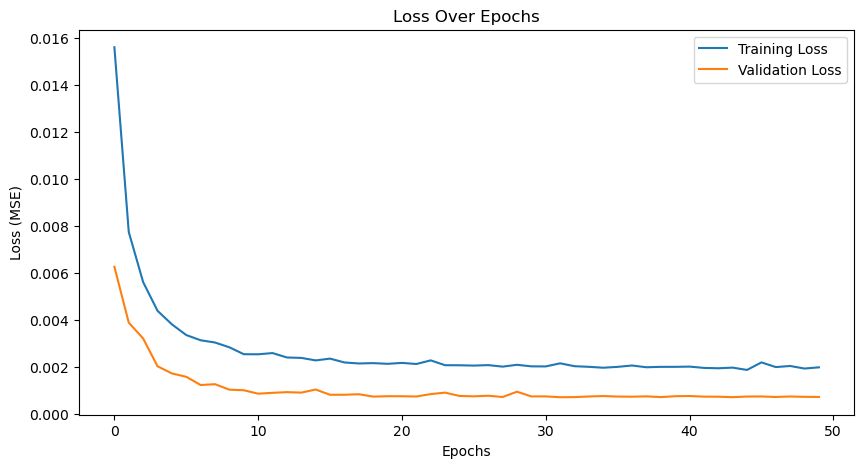

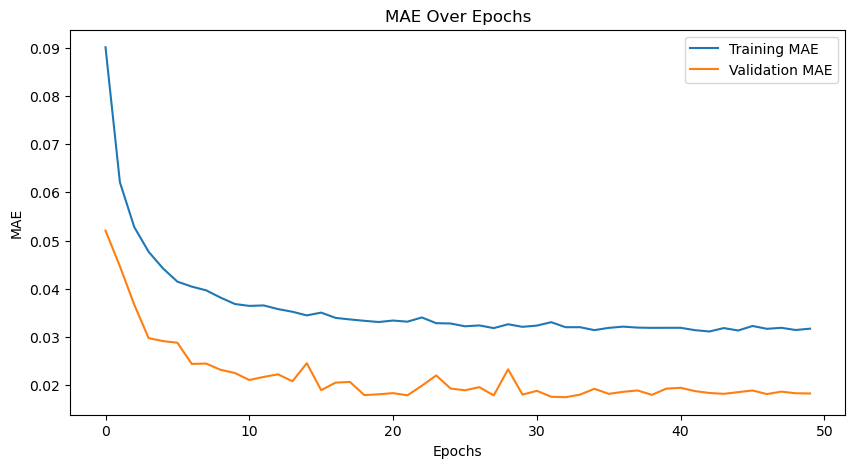

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(fit_model.history['loss'], label='Training Loss')
plt.plot(fit_model.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(fit_model.history['mae'], label='Training MAE')
plt.plot(fit_model.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


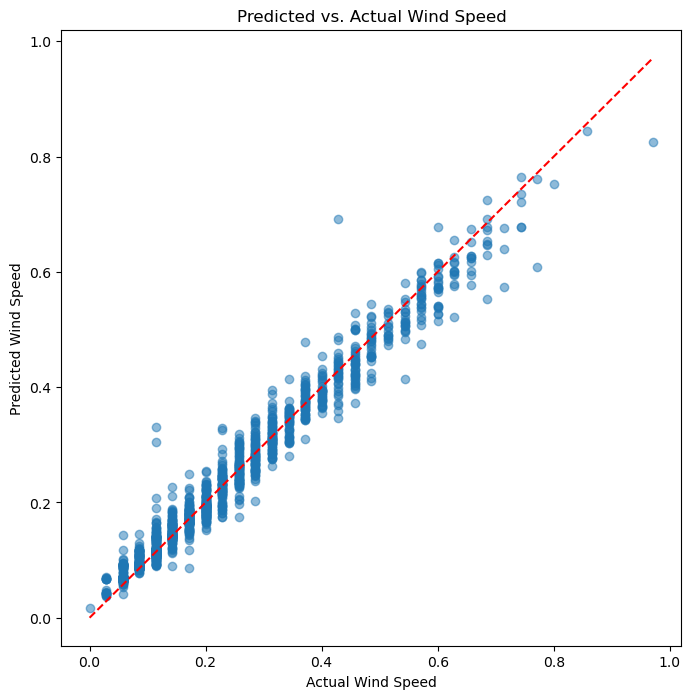

In [27]:
predictions = model.predict(test_X)

plt.figure(figsize=(8, 8))
plt.scatter(test_y, predictions, alpha=0.5)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color='red', linestyle='--')
plt.title('Predicted vs. Actual Wind Speed')
plt.xlabel('Actual Wind Speed')
plt.ylabel('Predicted Wind Speed')
plt.show()

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


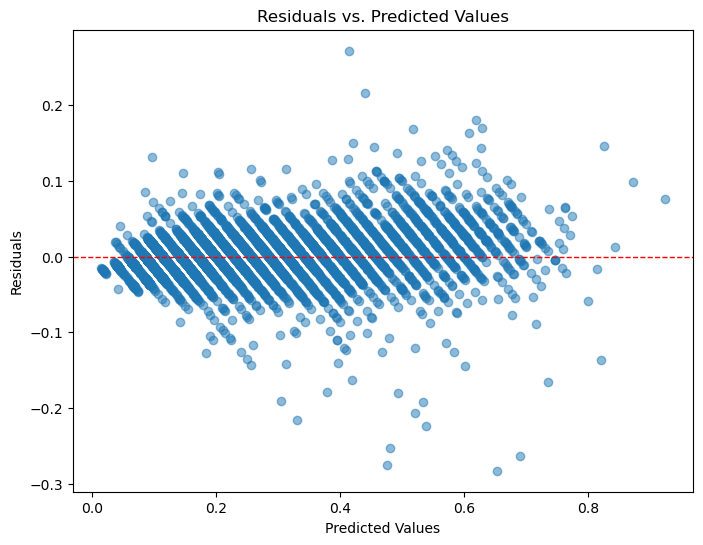

In [36]:
predictions = model.predict(sequences)
residuals = targets - predictions.flatten()

plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [29]:
# Calculate r-squared

predictions = model.predict(test_X)

r2 = r2_score(test_y, predictions)
r2

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


0.9707167963778256